# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файлов 

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from scipy import stats as st

import copy

In [83]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [84]:
# напишем функцию для вывода необходимой информации о датафрейме
def info(table):
    print('info()')
    table.info()
    print()
    print('названия столбцов')
    display(table.columns)
    print('первые 5 строк таблицы')
    display(table.head())
    print('describe()')
    display(table.describe())
    print('количество пропусков')
    display(table.isna().sum())
    print('доля пропусков (в процентах)')
    display(table.isna().mean().apply('{:.0%}'.format))
    print('количество дубликатов:', table.duplicated().sum())
    return

### Данные о звонках

In [85]:
# применим нашу функцию
info(calls)

info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

названия столбцов


Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

первые 5 строк таблицы


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


describe()


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


количество пропусков


id           0
call_date    0
duration     0
user_id      0
dtype: int64

доля пропусков (в процентах)


id           0%
call_date    0%
duration     0%
user_id      0%
dtype: object

количество дубликатов: 0


In [86]:
# приведем даты к соотвествующему типу данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# округлим значения времени звонков вверх
def ceil_value(value):
    return math.ceil(value)
calls['duration'] = calls['duration'].apply(ceil_value)   

# создадим доп столбец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

### Данные о пользовании интернетом

In [87]:
info(internet)

info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

названия столбцов


Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

первые 5 строк таблицы


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


describe()


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


количество пропусков


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

доля пропусков (в процентах)


Unnamed: 0      0%
id              0%
mb_used         0%
session_date    0%
user_id         0%
dtype: object

количество дубликатов: 0


In [88]:
# удаляем лишний ошибочный столбец 'Unnamed: 0'
internet.drop('Unnamed: 0', axis=1, inplace=True)

# приведем даты к соотвествующему типу данных
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# создадим доп столбец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

### Данные о сообщениях

In [89]:
info(messages)

info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

названия столбцов


Index(['id', 'message_date', 'user_id'], dtype='object')

первые 5 строк таблицы


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


describe()


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


количество пропусков


id              0
message_date    0
user_id         0
dtype: int64

доля пропусков (в процентах)


id              0%
message_date    0%
user_id         0%
dtype: object

количество дубликатов: 0


In [90]:
# приведем даты к соотвествующему типу данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# создадим доп столбец с месяцем
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

### Информация о трафиках

In [91]:
info(tariffs)

info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

названия столбцов


Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

первые 5 строк таблицы


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


describe()


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


количество пропусков


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

доля пропусков (в процентах)


messages_included        0%
mb_per_month_included    0%
minutes_included         0%
rub_monthly_fee          0%
rub_per_gb               0%
rub_per_message          0%
rub_per_minute           0%
tariff_name              0%
dtype: object

количество дубликатов: 0


### Данные клиентов

In [92]:
info(users)

info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

названия столбцов


Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

первые 5 строк таблицы


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


describe()


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


количество пропусков


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

доля пропусков (в процентах)


user_id        0%
age            0%
churn_date    92%
city           0%
first_name     0%
last_name      0%
reg_date       0%
tariff         0%
dtype: object

количество дубликатов: 0


In [93]:
# приведем даты в столбцах churn_date и reg_date к соответствующим форматам
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# добавим информацию о тарифах в users в виде 0 и 1
def tariff_id(object):
    if object == 'smart':
        return 0
    elif object == 'ultra':
        return 1
users['tariff_id'] = users['tariff'].apply(tariff_id)

**Вывод**

- привели даты к соотвествующему типу данных
- создали дополнительный столбец с месяцем
- удалили лишний ошибочный столбец `Unnamed: 0` в датафрейме `internet`, который видимо появился при сохранении датасета
- так как во всех тарифах длительность звонков округляется до минут, округлили значения времени звонков вверх

В датафрейме `users` в столбце `churn_date` 92% пропущенных значений. В этом столбце записана дата прекращения пользования тарифом. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Значит не будем трогать эти пропуски.

Других проблем в датафреймах найдено не было.

## Расчёт средних значений 

In [94]:
# функция создания сводной таблицы - количества минут, сообщений и мегабайт по месяцам
def amount_by_month_func(data_in, values_column, func):
    data_out = data_in.pivot_table(index = 'user_id', values = values_column, columns = 'month', aggfunc = func)
    data_out.reset_index(inplace = True)
    return data_out

In [95]:
# создадим массивы с количествами израсходованных ресурсов по месяцам по всем пользователям в том числе и с кол-вом звонков
amount_of_minutes_by_month = amount_by_month_func(calls, 'duration', 'sum')
number_of_minutes_by_month = amount_by_month_func(calls, 'duration', 'count')
amount_of_messages_by_month = amount_by_month_func(messages, 'id', 'count')
amount_of_mbs_by_month = amount_by_month_func(internet, 'mb_used', 'sum')

In [96]:
# создадим словарь для отображения списка таблиц и функций, чтобы всегда можно было быстро его вывести
my_dict = {}
def to_dict(data, name):
    my_dict[name] = data

to_dict(amount_of_minutes_by_month, 'amount_of_minutes_by_month')
to_dict(amount_of_messages_by_month, 'amount_of_messages_by_month')
to_dict(amount_of_mbs_by_month, 'amount_of_mbs_by_month')
to_dict(number_of_minutes_by_month, 'number_of_minutes_by_month')
to_dict(amount_by_month_func, 'amount_by_month_func')

In [97]:
# напишем функцию добавления столбца в таблицу с 0 или 1 в зав-ти от тарифа
def add_tariff_id_func(data):
    data = data.merge(users[['user_id', 'tariff_id']], on='user_id', how='right')
    return data

to_dict(add_tariff_id_func, 'add_tariff_id_func')

In [98]:
# добавим столбец с номером тарифа в наши таблицы с количеством ресурсов 
amount_of_minutes_by_month = add_tariff_id_func(amount_of_minutes_by_month)
amount_of_messages_by_month = add_tariff_id_func(amount_of_messages_by_month)
amount_of_mbs_by_month = add_tariff_id_func(amount_of_mbs_by_month)
number_of_minutes_by_month = add_tariff_id_func(number_of_minutes_by_month)

In [99]:
# напишем функцию добавления необходимых данных о тарифе в зависимости от 'tariff_id'
def tariffs_info(row, info_column):
    result = tariffs[info_column][row['tariff_id']]
    return result

def add_tariffs_info_func(data, info_column):
    data[info_column] = data.apply(tariffs_info, axis = 1, args = [info_column])
    return data

to_dict(add_tariffs_info_func, 'add_tariffs_info_func')

In [100]:
# создадим таблицы, в которых будут расчитываться превышения лимитов по затраченным ресурсам
my_dict.keys()
minutes_over_limit = copy.deepcopy(amount_of_minutes_by_month)
messages_over_limit = copy.deepcopy(amount_of_messages_by_month)
mbs_over_limit = copy.deepcopy(amount_of_mbs_by_month)

to_dict(minutes_over_limit, 'minutes_over_limit')
to_dict(messages_over_limit, 'messages_over_limit')
to_dict(mbs_over_limit, 'mbs_over_limit')

In [101]:
# добавим столбцы с информацией о тарифах в будущие таблицы с превышениями 
add_tariffs_info_func(minutes_over_limit, 'minutes_included')
add_tariffs_info_func(messages_over_limit, 'messages_included')
add_tariffs_info_func(mbs_over_limit, 'mb_per_month_included')

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mb_per_month_included
0,1000,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,1,30720
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,0,15360
2,1002,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,0,15360
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,1,30720
4,1004,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,1,30720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76,1,30720
496,1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15,0,15360
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11500.29,14156.08,19918.60,0,15360
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,7476.24,24235.21,22134.41,20579.36,NaN,NaN,0,15360


In [102]:
# напишем функцию расчёта превышения лимитов
def over_limit(row, value_column, limit_column):
    result = float(row[value_column]) - float(row[limit_column])
    if result > 0:
        return result
    elif result <= 0:
        return 0
    
def to_over_limit_func(data, limit_column):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(over_limit, axis = 1, args = [i, limit_column])
    return data

In [103]:
# перепишем количество израсходованных митут, сообщений и мегабайт на количество превышений лимитов
print('превышение лимита минут')
display(to_over_limit_func(minutes_over_limit, 'minutes_included'))
print('превышение лимита сообщений')
display(to_over_limit_func(messages_over_limit, 'messages_included'))
print('превышение лимита мб')
display(to_over_limit_func(mbs_over_limit, 'mb_per_month_included'))

my_dict.keys()

превышение лимита минут


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,minutes_included
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,500
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,3000
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,3000
496,1496,0.0,94.0,57.0,21.0,0.0,55.0,82.0,27.0,0.0,0.0,162.0,18.0,0,500
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,45.0,0,500
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0,500


превышение лимита сообщений


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,messages_included
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,50
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,50
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,1000
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,1000
496,1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,50
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,50
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.0,0.0,0.0,NaN,NaN,0,50


превышение лимита мб


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mb_per_month_included
0,1000,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,30720
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3069.34,0.00,0,15360
2,1002,NaN,NaN,NaN,NaN,NaN,0.00,2220.10,4959.26,1331.08,0.00,3227.28,2753.73,0,15360
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1,30720
4,1004,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,30720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2347.62,0.00,8219.11,0.00,1,30720
496,1496,0.0,13129.67,9599.0,5714.67,8349.75,4774.31,9004.76,8170.03,11574.65,12823.17,9703.40,5376.15,0,15360
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,4558.60,0,15360
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.00,8875.21,6774.41,5219.36,NaN,NaN,0,15360


dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit'])

In [104]:
# создадим таблицы, в которых будут расчитываться прибыли
profit_per_minutes = copy.deepcopy(minutes_over_limit)
profit_per_messages = copy.deepcopy(messages_over_limit)
profit_per_mbs = copy.deepcopy(mbs_over_limit)
to_dict(profit_per_minutes, 'profit_per_minutes')
to_dict(profit_per_messages, 'profit_per_messages')
to_dict(profit_per_mbs, 'profit_per_mbs')

# добавим столбцы со стоимостью минут, сообщений и мб в зависимости от тарифа
add_tariffs_info_func(profit_per_minutes, 'rub_per_minute')
add_tariffs_info_func(profit_per_messages, 'rub_per_message')
add_tariffs_info_func(profit_per_mbs, 'rub_per_gb')

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mb_per_month_included,rub_per_gb
0,1000,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,30720,150
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3069.34,0.00,0,15360,200
2,1002,NaN,NaN,NaN,NaN,NaN,0.00,2220.10,4959.26,1331.08,0.00,3227.28,2753.73,0,15360,200
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,1,30720,150
4,1004,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,30720,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2347.62,0.00,8219.11,0.00,1,30720,150
496,1496,0.0,13129.67,9599.0,5714.67,8349.75,4774.31,9004.76,8170.03,11574.65,12823.17,9703.40,5376.15,0,15360,200
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,4558.60,0,15360,200
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.00,8875.21,6774.41,5219.36,NaN,NaN,0,15360,200


In [105]:
# функция расчёта прибыли за минуты по месяцам в строке
def profit_per_minutes_func(row, value_column):
    result = row[value_column] * row['rub_per_minute']
    return result

# функция расчёта прибыли за сообщения по месяцам в строке
def profit_per_messages_func(row, value_column):
    result = row[value_column] * row['rub_per_message']
    return result

# функция расчёта прибыли за интернет по месяцам в строке
def profit_per_mbs_func(row, value_column):
    try:
        result = math.ceil(row[value_column] / 1024) * row['rub_per_gb']
        return result
    except:
        return row[value_column]

# функция расчёта прибыли 
def profit_func(data, func):
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        data[i] = data.apply(func, axis = 1, args = [i])
    return data

to_dict(profit_func, 'profit_func')

In [106]:
# рассчитаем прибыль
print('Прибыль от продажи минут')
display(profit_func(profit_per_minutes, profit_per_minutes_func))
print('Прибыль от продажи сообщений')
display(profit_func(profit_per_messages, profit_per_messages_func))
print('Прибыль от продажи мб')
display(profit_func(profit_per_mbs, profit_per_mbs_func))
my_dict.keys()

Прибыль от продажи минут


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,minutes_included,rub_per_minute
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,500,3
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,500,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,3000,1
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,3000,1
496,1496,0.0,282.0,171.0,63.0,0.0,165.0,246.0,81.0,0.0,0.0,486.0,54.0,0,500,3
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,135.0,0,500,3
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0,500,3


Прибыль от продажи сообщений


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,messages_included,rub_per_message
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,50,3
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,50,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,1000,1
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,1000,1
496,1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0,50,3
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,50,3
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,36.0,0.0,0.0,NaN,NaN,0,50,3


Прибыль от продажи мб


,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mb_per_month_included,rub_per_gb
0,1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30720,150
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.0,0.0,0,15360,200
2,1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,0,15360,200
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1,30720,150
4,1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30720,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,450.0,0.0,1350.0,0.0,1,30720,150
496,1496,0.0,2600.0,2000.0,1200.0,1800.0,1000.0,1800.0,1600.0,2400.0,2600.0,2000.0,1200.0,0,15360,200
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1000.0,0,15360,200
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1800.0,1400.0,1200.0,NaN,NaN,0,15360,200


dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit', 'profit_per_minutes', 'profit_per_messages', 'profit_per_mbs', 'profit_func'])

In [107]:
# напишем функцию расчёта среднего значения за 12 месяцев
def mean_per_year(row):
    mean = row[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].mean()
    return mean

# напишем функцию добавления столбца со средними по году значениями
def add_mean_per_year_func(data, column_name):
    data[column_name] = data.apply(mean_per_year, axis = 1)
    return data

to_dict(add_mean_per_year_func, 'add_mean_per_year_func')

# добавим средние по году значения в доп. столбцы
add_mean_per_year_func(amount_of_minutes_by_month, 'mean_duration')
add_mean_per_year_func(amount_of_messages_by_month, 'mean_messages')
add_mean_per_year_func(amount_of_mbs_by_month, 'mean_mbs')
add_mean_per_year_func(number_of_minutes_by_month, 'mean_calls')
add_mean_per_year_func(minutes_over_limit, 'mean_minutes_over_limit')
add_mean_per_year_func(messages_over_limit, 'mean_messages_over_limit')
add_mean_per_year_func(mbs_over_limit, 'mean_mbs_over_limit')
add_mean_per_year_func(profit_per_minutes, 'mean_profit_per_minutes')
add_mean_per_year_func(profit_per_messages, 'mean_profit_per_messages')
add_mean_per_year_func(profit_per_mbs, 'mean_profit_per_mbs')
my_dict.keys()


dict_keys(['amount_of_minutes_by_month', 'amount_of_messages_by_month', 'amount_of_mbs_by_month', 'number_of_minutes_by_month', 'amount_by_month_func', 'add_tariff_id_func', 'add_tariffs_info_func', 'minutes_over_limit', 'messages_over_limit', 'mbs_over_limit', 'profit_per_minutes', 'profit_per_messages', 'profit_per_mbs', 'profit_func', 'add_mean_per_year_func'])

In [108]:
amount_of_minutes_by_month

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff_id,mean_duration
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,1,320.750000
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,0,422.000000
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,0,216.714286
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,1,764.400000
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,1,123.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0,1,784.000000
496,1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0,0,498.666667
497,1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0,0,468.666667
498,1498,NaN,NaN,NaN,NaN,NaN,NaN,175.0,400.0,471.0,247.0,NaN,NaN,0,323.250000


In [109]:
# объединим все необходимые нам столбцы в один массив
# функция объединения выбранных столбцов из таблиц
def merge_func(data1, data2, list_columns_data2):
    list_columns_data2.insert(0, 'user_id')
    df = data1.merge(data2[list_columns_data2], on='user_id', how='right')
    return df

to_dict(merge_func, 'merge_func')

In [110]:
# создадим генеральную таблицу и добавим туда все необходимые столбцы
general_table = merge_func(amount_of_minutes_by_month[['user_id', 'tariff_id', 'mean_duration']], 
                           amount_of_messages_by_month, ['mean_messages'])
general_table = merge_func(general_table, amount_of_mbs_by_month, ['mean_mbs'])
general_table = merge_func(general_table, number_of_minutes_by_month, ['mean_calls'])
general_table = merge_func(general_table, minutes_over_limit, ['mean_minutes_over_limit'])
general_table = merge_func(general_table, messages_over_limit, ['mean_messages_over_limit'])
general_table = merge_func(general_table, mbs_over_limit, ['mean_mbs_over_limit'])
general_table = merge_func(general_table, profit_per_minutes, ['mean_profit_per_minutes'])
general_table = merge_func(general_table, profit_per_messages, ['mean_profit_per_messages'])
general_table = merge_func(general_table, profit_per_mbs, ['mean_profit_per_mbs'])
general_table = merge_func(general_table, users, ['city'])
general_table.columns

Index(['user_id', 'tariff_id', 'mean_duration', 'mean_messages', 'mean_mbs',
       'mean_calls', 'mean_minutes_over_limit', 'mean_messages_over_limit',
       'mean_mbs_over_limit', 'mean_profit_per_minutes',
       'mean_profit_per_messages', 'mean_profit_per_mbs', 'city'],
      dtype='object')

In [111]:
to_dict(general_table, 'general_table')

In [112]:
# поменяем порядок столбцов
general_table = general_table[['user_id', 'tariff_id', 'city', 'mean_calls', 'mean_duration', 'mean_minutes_over_limit', 
       'mean_messages', 'mean_messages_over_limit','mean_mbs',
       'mean_mbs_over_limit', 'mean_profit_per_minutes', 'mean_profit_per_messages', 'mean_profit_per_mbs']]

In [113]:
# заполним проауски нулями, в данном случае NaN значит, что клиент не пользовался услугой
general_table.fillna(0)

,user_id,tariff_id,city,mean_calls,mean_duration,mean_minutes_over_limit,mean_messages,mean_messages_over_limit,mean_mbs,mean_mbs_over_limit,mean_profit_per_minutes,mean_profit_per_messages,mean_profit_per_mbs
0,1000,1,Краснодар,46.0,320.750000,0.0,62.0,0.000000,13424.038750,0.000000,0.0,0.00,0.000000
1,1001,0,Москва,61.0,422.000000,0.0,0.0,0.000000,16233.000000,1534.670000,0.0,0.00,300.000000
2,1002,0,Стерлитамак,31.0,216.714286,0.0,10.0,0.000000,16576.645714,2070.207143,0.0,0.00,485.714286
3,1003,1,Москва,104.0,764.400000,0.0,76.0,0.000000,11456.128000,0.000000,0.0,0.00,0.000000
4,1004,1,Новокузнецк,22.0,123.375000,0.0,149.0,0.000000,18629.935000,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,1,Иркутск,113.0,784.000000,0.0,68.0,0.000000,25482.112000,2113.346000,0.0,0.00,360.000000
496,1496,0,Вологда,69.0,498.666667,43.0,39.0,0.083333,22578.524167,8184.963333,129.0,0.25,1683.333333
497,1497,0,Челябинск,67.0,468.666667,15.0,17.0,0.000000,15191.656667,1519.533333,45.0,0.00,333.333333
498,1498,0,Владикавказ,45.0,323.250000,0.0,42.0,3.000000,18606.305000,5217.245000,0.0,9.00,1100.000000


In [114]:
# добавим столбец с минимальной стоимостью тарифа
add_tariffs_info_func(general_table, 'rub_monthly_fee')

/tmp/ipykernel_57/3937974738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[info_column] = data.apply(tariffs_info, axis = 1, args = [info_column])


,user_id,tariff_id,city,mean_calls,mean_duration,mean_minutes_over_limit,mean_messages,mean_messages_over_limit,mean_mbs,mean_mbs_over_limit,mean_profit_per_minutes,mean_profit_per_messages,mean_profit_per_mbs,rub_monthly_fee
0,1000,1,Краснодар,46.0,320.750000,0.0,62.0,0.000000,13424.038750,0.000000,0.0,0.00,0.000000,1950
1,1001,0,Москва,61.0,422.000000,0.0,NaN,NaN,16233.000000,1534.670000,0.0,NaN,300.000000,550
2,1002,0,Стерлитамак,31.0,216.714286,0.0,10.0,0.000000,16576.645714,2070.207143,0.0,0.00,485.714286,550
3,1003,1,Москва,104.0,764.400000,0.0,76.0,0.000000,11456.128000,0.000000,0.0,0.00,0.000000,1950
4,1004,1,Новокузнецк,22.0,123.375000,0.0,149.0,0.000000,18629.935000,0.000000,0.0,0.00,0.000000,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,1,Иркутск,113.0,784.000000,0.0,68.0,0.000000,25482.112000,2113.346000,0.0,0.00,360.000000,1950
496,1496,0,Вологда,69.0,498.666667,43.0,39.0,0.083333,22578.524167,8184.963333,129.0,0.25,1683.333333,550
497,1497,0,Челябинск,67.0,468.666667,15.0,17.0,0.000000,15191.656667,1519.533333,45.0,0.00,333.333333,550
498,1498,0,Владикавказ,45.0,323.250000,0.0,42.0,3.000000,18606.305000,5217.245000,0.0,9.00,1100.000000,550


In [115]:
# посчитаем среднюю прибыль по клиентам
def mean_profit_func(row):
    result = row[['mean_profit_per_minutes', 'mean_profit_per_messages', 'mean_profit_per_mbs', 'rub_monthly_fee']].sum()
    return result
general_table['mean_profit'] = general_table.apply(mean_profit_func, axis = 1)

/tmp/ipykernel_57/1394957345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_table['mean_profit'] = general_table.apply(mean_profit_func, axis = 1)


In [116]:
# создадим две таблицы по тарифам
smart = general_table[general_table['tariff_id'] == 0]
ultra = general_table[general_table['tariff_id'] == 1]
display(smart)
display(ultra)

,user_id,tariff_id,city,mean_calls,mean_duration,mean_minutes_over_limit,mean_messages,mean_messages_over_limit,mean_mbs,mean_mbs_over_limit,mean_profit_per_minutes,mean_profit_per_messages,mean_profit_per_mbs,rub_monthly_fee,mean_profit
1,1001,0,Москва,61.0,422.000000,0.000000,NaN,NaN,16233.000000,1534.670000,0.00,NaN,300.000000,550,850.000000
2,1002,0,Стерлитамак,31.0,216.714286,0.000000,10.0,0.000000,16576.645714,2070.207143,0.00,0.00,485.714286,550,1035.714286
5,1005,0,Набережные Челны,74.0,550.416667,89.583333,46.0,2.750000,8307.275833,0.000000,268.75,8.25,0.000000,550,827.000000
6,1006,0,Ульяновск,46.0,318.272727,0.000000,NaN,NaN,14926.255455,1645.770909,0.00,NaN,381.818182,550,931.818182
7,1007,0,Москва,68.0,486.555556,39.666667,25.0,0.000000,14625.074444,997.104444,119.00,0.00,244.444444,550,913.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1494,0,Омск,55.0,389.200000,0.200000,NaN,NaN,15398.832000,1792.682000,0.60,NaN,440.000000,550,990.600000
496,1496,0,Вологда,69.0,498.666667,43.000000,39.0,0.083333,22578.524167,8184.963333,129.00,0.25,1683.333333,550,2362.583333
497,1497,0,Челябинск,67.0,468.666667,15.000000,17.0,0.000000,15191.656667,1519.533333,45.00,0.00,333.333333,550,928.333333
498,1498,0,Владикавказ,45.0,323.250000,0.000000,42.0,3.000000,18606.305000,5217.245000,0.00,9.00,1100.000000,550,1659.000000


,user_id,tariff_id,city,mean_calls,mean_duration,mean_minutes_over_limit,mean_messages,mean_messages_over_limit,mean_mbs,mean_mbs_over_limit,mean_profit_per_minutes,mean_profit_per_messages,mean_profit_per_mbs,rub_monthly_fee,mean_profit
0,1000,1,Краснодар,46.000,320.750000,0.0,62.000,0.0,13424.038750,0.000,0.0,0.0,0.0,1950,1950.0
3,1003,1,Москва,104.000,764.400000,0.0,76.000,0.0,11456.128000,0.000,0.0,0.0,0.0,1950,1950.0
4,1004,1,Новокузнецк,22.000,123.375000,0.0,149.000,0.0,18629.935000,0.000,0.0,0.0,0.0,1950,1950.0
13,1013,1,Иваново,71.000,468.000000,0.0,21.000,0.0,15258.580000,0.000,0.0,0.0,0.0,1950,1950.0
16,1016,1,Омск,10.000,61.000000,0.0,71.000,0.0,13405.220000,0.000,0.0,0.0,0.0,1950,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,1476,1,Москва,68.625,525.500000,0.0,5.625,0.0,16698.434444,0.000,0.0,0.0,0.0,1950,1950.0
485,1485,1,Киров,94.000,584.000000,0.0,155.000,0.0,23422.760000,0.000,0.0,0.0,0.0,1950,1950.0
491,1491,1,Челябинск,72.000,513.333333,0.0,48.000,0.0,17940.248889,0.000,0.0,0.0,0.0,1950,1950.0
493,1493,1,Красноярск,55.000,372.000000,0.0,47.000,0.0,27209.685000,6007.590,0.0,0.0,900.0,1950,2850.0


## Поведение пользователей разных тарифов

In [117]:
smart[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_minutes_over_limit', 
      'mean_messages_over_limit', 'mean_mbs_over_limit', 'mean_profit']].describe()

,mean_duration,mean_messages,mean_mbs,mean_minutes_over_limit,mean_messages_over_limit,mean_mbs_over_limit,mean_profit
count,349.000000,302.000000,350.000000,349.000000,302.000000,350.000000,351.000000
mean,420.840147,37.575606,16190.427408,45.871620,6.814128,2864.037178,1322.451159
std,143.473707,24.849738,3577.215353,70.179829,13.027865,2629.552917,606.464517
min,12.363636,1.000000,5384.218182,0.000000,0.000000,0.000000,550.000000
25%,317.545455,19.000000,13947.652500,0.000000,0.000000,653.388194,865.476190
50%,425.250000,33.000000,16267.380000,12.000000,0.000000,2216.865000,1176.400000
75%,520.400000,54.000000,18595.710972,67.000000,7.375000,4437.713786,1667.166667
max,891.500000,118.000000,27286.960000,467.500000,72.375000,14699.520000,4333.333333


In [118]:
ultra[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_minutes_over_limit', 
      'mean_messages_over_limit', 'mean_mbs_over_limit', 'mean_profit']].describe()

,mean_duration,mean_messages,mean_mbs,mean_minutes_over_limit,mean_messages_over_limit,mean_mbs_over_limit,mean_profit
count,143.000000,124.000000,147.000000,143.0,124.0,147.000000,149.000000
mean,546.685442,64.555802,19726.550619,0.0,0.0,862.925653,2085.548788
std,268.338363,43.390612,8170.823338,0.0,0.0,1913.302600,297.732421
min,9.428571,3.000000,2301.760000,0.0,0.0,0.000000,1950.000000
25%,342.883333,28.000000,14806.842000,0.0,0.0,0.000000,1950.000000
50%,525.500000,57.800000,18829.486667,0.0,0.0,0.000000,1950.000000
75%,750.000000,89.000000,25964.860000,0.0,0.0,175.158750,1987.500000
max,1179.363636,192.000000,38463.570000,0.0,0.0,8580.637500,3225.000000


In [119]:
print('SMART, в среднем за месяц:')
print()
print('Минут разговора:', int(smart['mean_duration'].describe()['mean']), 'из 500 входящих в лимит')
print('Сообщений:', int(smart['mean_messages'].describe()['mean']), 'из 50 входящих в лимит')
print('Мегабайт интернета:', "{:.1f}".format(smart['mean_mbs'].describe()['mean']), 'из 15000 входящих в лимит')
print()
print('Стандартное отклонение минут разговора:', smart['mean_duration'].describe()['std'])
print('Стандартное отклонение сообщений:', smart['mean_messages'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', smart['mean_mbs'].describe()['std'])
print()
print('Дисперсия минут разговора:', smart['mean_duration'].describe()['std'] ** 2)
print('Дисперсия сообщений:', smart['mean_messages'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', smart['mean_mbs'].describe()['std'] ** 2)
print()
print('Лимит минут в среднем превышен на:', int(smart['mean_minutes_over_limit'].describe()['mean']))
print('Лимит сообщений в среднем превышен на:', int(smart['mean_messages_over_limit'].describe()['mean']))
print('Лимит мегабайт в среднем превышен на:', "{:.1f}".format(smart['mean_mbs_over_limit'].describe()['mean']))
print()
print(f"Прибыль от тарифа в диапозоне от {int(smart['mean_profit'].describe()['min'])} до {int(smart['mean_profit'].describe()['max'])}")
print(f"Средняя прибыль от тарифа: {int(smart['mean_profit'].describe()['mean'])}")
print()
print('ULTRA, в среднем за месяц:')
print()
print('Минут разговора:', int(ultra['mean_duration'].describe()['mean']), 'из 3000 входящих в лимит')
print('Сообщений:', int(ultra['mean_messages'].describe()['mean']), 'из 1000 входящих в лимит')
print('Мегабайт интернета:', "{:.1f}".format(ultra['mean_mbs'].describe()['mean']), 'из 30000 входящих в лимит')
print()
print('Стандартное отклонение минут разговора:', ultra['mean_duration'].describe()['std'])
print('Стандартное отклонение сообщений:', ultra['mean_messages'].describe()['std'])
print('Стандартное отклонение мегабайт интернета:', ultra['mean_mbs'].describe()['std'])
print()
print('Дисперсия минут разговора:', ultra['mean_duration'].describe()['std'] ** 2)
print('Дисперсия сообщений:', ultra['mean_messages'].describe()['std'] ** 2)
print('Дисперсия мегабайт интернета:', ultra['mean_mbs'].describe()['std'] ** 2)
print()
print('Лимит минут в среднем превышен на:', int(ultra['mean_minutes_over_limit'].describe()['mean']))
print('Лимит сообщений в среднем превышен на:', int(ultra['mean_messages_over_limit'].describe()['mean']))
print('Лимит мегабайт в среднем превышен на:', "{:.1f}".format(ultra['mean_mbs_over_limit'].describe()['mean']))
print()
print(f"Прибыль от тарифа в диапозоне от {int(ultra['mean_profit'].describe()['min'])} до {int(ultra['mean_profit'].describe()['max'])}")
print(f"Средняя прибыль от тарифа: {int(ultra['mean_profit'].describe()['mean'])}")

SMART, в среднем за месяц:

Минут разговора: 420 из 500 входящих в лимит
Сообщений: 37 из 50 входящих в лимит
Мегабайт интернета: 16190.4 из 15000 входящих в лимит

Стандартное отклонение минут разговора: 143.47370661828933
Стандартное отклонение сообщений: 24.849738360517687
Стандартное отклонение мегабайт интернета: 3577.215353014484

Дисперсия минут разговора: 20584.70449079096
Дисперсия сообщений: 617.5094965861842
Дисперсия мегабайт интернета: 12796469.681842541

Лимит минут в среднем превышен на: 45
Лимит сообщений в среднем превышен на: 6
Лимит мегабайт в среднем превышен на: 2864.0

Прибыль от тарифа в диапозоне от 550 до 4333
Средняя прибыль от тарифа: 1322

ULTRA, в среднем за месяц:

Минут разговора: 546 из 3000 входящих в лимит
Сообщений: 64 из 1000 входящих в лимит
Мегабайт интернета: 19726.6 из 30000 входящих в лимит

Стандартное отклонение минут разговора: 268.3383634311222
Стандартное отклонение сообщений: 43.390612090133864
Стандартное отклонение мегабайт интернета: 81

## Построим графики распределения

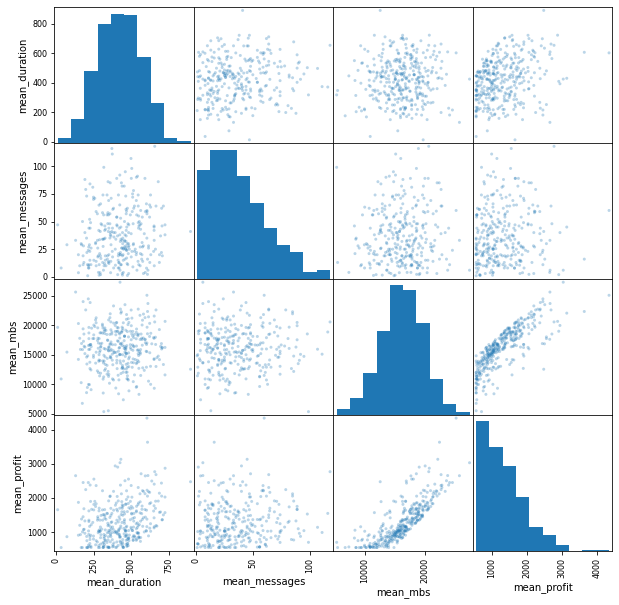

In [120]:
pd.plotting.scatter_matrix(smart[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_profit']], alpha = 0.3, figsize = (10,10));

---
### Распределения - тариф "Смарт"
1. Кол-во минут - нормальное 
2. Кол-во сообщений - распределение Пуассона
3. Кол-во мегабайт - нормальное
---

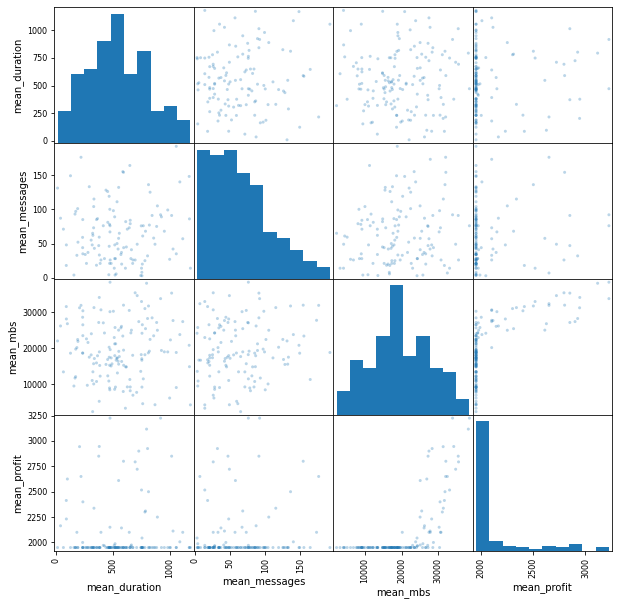

In [73]:
pd.plotting.scatter_matrix(ultra[['mean_duration', 'mean_messages', 'mean_mbs', 'mean_profit']], alpha = 0.3, figsize = (10,10));

---
### Распределения - тариф "Ультра"
1. Кол-во минут - нормальное 
2. Кол-во сообщений - распределение Пуассона
3. Кол-во мегабайт - нормальное
---

## Проверим гипотезы
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

---
### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Нулевой гипотезой будет гипотеза о том, что средние наших выборок равны.
Альтернативной гипотезой будет наша гипотеза **"Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"*.

Используем метод `scipy.stats.ttest_ind (array1, array2, equal_var = False)`. False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости зададим 0.05, чтобы вероятность правильности вывода была 95% и больше.

In [40]:
alpha = 0.05
results = st.ttest_ind(smart['mean_profit'], ultra['mean_profit'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 7.582300754577309e-60
Отвергаем нулевую гипотезу


**Вывод по гипотезе 1:**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок и очень маленькое p-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается!

А значит сформулированная нами альтернативная гипотеза о том, что средние наших выборок отличаются, не отвергается!

---

### Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотезы создадим две соответствующие таблицы moscow и other. В обеих таблицах будут пользователи обоих тарифов, нужно проверить, чтобы их соотношение в обеих таблицах было примерно одинаково, иначе придётся проверять гипотезу не по 2, а по 4 выборкам - Москва - смарт, Москва - ультра, не Москва - смарт, не Москва - ультра.

Критический уровень значимости поставим 0.05, чтобы вероятность правильности вывода была 95% и больше.

Воспользуемся методом `scipy.stats.ttest_ind(array1, array2, equal_var = False)`. Equal_var будет False, потому что, если считать дисперсию каждой выборки отдельно, то точность теста будет выше.

In [41]:
# создадим две таблицы, в одной будут все клиенты из Москвы, во второй - все остальные
moscow = general_table[general_table['city'] == 'Москва']
other = general_table[general_table['city'] != 'Москва']

In [42]:
# проверим соотношения пользователей разных тарифов в наших выборках
display(moscow.pivot_table(index = 'tariff_id', values = 'mean_profit', aggfunc = 'count'))
display(other.pivot_table(index = 'tariff_id', values = 'mean_profit', aggfunc = 'count'))

,mean_profit
tariff_id,
0,67
1,32


,mean_profit
tariff_id,
0,284
1,117


И в Москве, и в других городах соотношение пользователей тарифов СМАРТ и УЛЬТРА примерно 2 к 1 соответственно. Можем смело проверять гипотезу по 2м выборкам.

In [43]:
alpha = 0.05
results = st.ttest_ind(moscow['mean_profit'], other['mean_profit'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.3540820152308114
Не получилось отвергнуть нулевую гипотезу


**Вывод по гипотезе 2:**

Соотношение в двух наших таблицах клиентов с разными тарифами примерно одинаковое, поэтому нам не пришлось создавать 4 таблицы.

Полученное нами p-value равно 0.35, а значит есть большая вероятность того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних мы отвергаем!

---

# Общий вывод

- Вывели из предоставленных таблиц все необходимые средние значения израсходованных минут, мегабайт и сообщений.
- Вывели прибыль по ним по каждому месяцу и посчитали среднюю прибыль для компании по каждому из клиентов. 
- Разделили всех клиентов по тарифным группам и проверили правильность нашех гипотез. 

Действительно, средняя прибыльность в двух тарифах отличается, более того, мы заметили, что средние израсходованные кол-во звонков, кол-во сообщений и кол-во мегабайт интернет трафика не так сильно отличаются между тарифами, тогда как базовая стоимость тарифов отличается почти в 4 раза!

**Прибыль тарифа УЛЬТРА выше прибыли тарифа СМАРТ.**